# 1) Environment Setup

## 1.1 建立合成音訊

In [ ]:
# install piper-sample-generator (currently only supports linux systems)
# !git clone https://github.com/rhasspy/piper-sample-generator
# !wget -O piper-sample-generator/models/en_US-libritts_r-medium.pt 'https://github.com/rhasspy/piper-sample-generator/releases/download/v2.0.0/en_US-libritts_r-medium.pt'
# !pip install piper-phonemize
# !pip install webrtcvad

## 1.2 安裝 openwakeword 記得修改一行程式

In [ ]:
# install openwakeword (full installation to support training)
# !git clone https://github.com/dscripka/openwakeword
# !pip install -e ./openwakeword
# !cd openwakeword

## 1.3 安裝其他依賴

In [ ]:
# install other dependencies
!pip install mutagen==1.47.0
!pip install torchinfo==1.8.0
!pip install torchmetrics==1.2.0
!pip install speechbrain==0.5.14
!pip install audiomentations==0.33.0
!pip install torch-audiomentations==0.11.0
!pip install acoustics==0.2.6
# !pip install tensorflow-cpu==2.8.1
# !pip install tensorflow_probability==0.16.0
# !pip install onnx_tf==1.10.0
!pip install pronouncing==0.2.0
!pip install datasets==2.14.6
!pip install deep-phonemizer==0.0.19

## 1.4 下載 openwakeowrd 所需模型

In [ ]:
# Download required models (workaround for Colab)
import os
os.makedirs("./openwakeword/openwakeword/resources/models")
!wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/embedding_model.onnx -O ./openwakeword/openwakeword/resources/models/embedding_model.onnx
!wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/embedding_model.tflite -O ./openwakeword/openwakeword/resources/models/embedding_model.tflite
!wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/melspectrogram.onnx -O ./openwakeword/openwakeword/resources/models/melspectrogram.onnx
!wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/melspectrogram.tflite -O ./openwakeword/openwakeword/resources/models/melspectrogram.tflite

In [ ]:
## 1.5 導入 套件

In [2]:
# Imports

import os
import collections
import numpy as np
from numpy.lib.format import open_memmap
from pathlib import Path
from tqdm import tqdm
import openwakeword
import openwakeword.data
import openwakeword.utils
import openwakeword.metrics

import scipy
import datasets
import matplotlib.pyplot as plt
import torch
from torch import nn
import IPython.display as ipd

/opt/conda/lib/python3.11/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
torchvision is not available - cannot save figures


# 2) 準備正負樣本

In [10]:
# Create audio pre-processing object to get openWakeWord audio embeddings

F = openwakeword.utils.AudioFeatures()

## 2.1 準備負樣本先
- Common Voice 11 dataset  for speech.
- fma-large dataset for music
- mit_rirs dataset for noise

### 2.1.1 - Common Voice 11 dataset

In [41]:
# Download CV11 test split from HuggingFace, and convert the audio into 16 khz, 16-bit wav files

cv_11 = datasets.load_dataset("mozilla-foundation/common_voice_11_0", "zh-TW", split="test", streaming=True)
cv_11 = cv_11.cast_column("audio", datasets.Audio(sampling_rate=16000, mono=True)) # convert to 16-khz
cv_11 = iter(cv_11)

# Convert and save clips (only first 200)
limit = 2000
for i in tqdm(range(limit)):
    example = next(cv_11)
    output = os.path.join("cv11_zh-tw_test_clips", example["path"][0:-4] + ".wav")
    os.makedirs(os.path.dirname(output), exist_ok=True)

    wav_data = (example["audio"]["array"]*32767).astype(np.int16) # convert to 16-bit PCM format
    scipy.io.wavfile.write(output, 16000, wav_data)


  0%|          | 0/2000 [00:00<?, ?it/s]
ding metadata...: 0it [00:00, ?it/s]
Reading metadata...: 4709it [00:00, 14179.10it/s]
100%|██████████| 2000/2000 [00:14<00:00, 142.50it/s]


### 2.1.2 - fma dataset

In [ ]:
# Free Music Archive dataset (https://github.com/mdeff/fma)
output_dir = "./fma"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
fma_dataset = datasets.load_dataset("rudraml/fma", name="small", split="train", streaming=True)
fma_dataset = iter(fma_dataset.cast_column("audio", datasets.Audio(sampling_rate=16000)))

n_hours = 1  # use only 1 hour of clips for this example notebook, recommend increasing for full-scale training
for i in tqdm(range(n_hours*3600//30)):  # this works because the FMA dataset is all 30 second clips
    row = next(fma_dataset)
    name = row['audio']['path'].split('/')[-1].replace(".mp3", ".wav")
    scipy.io.wavfile.write(os.path.join(output_dir, name), 16000, (row['audio']['array']*32767).astype(np.int16))
    i += 1
    if i == n_hours*3600//30:
        break

### 2.1.3 - mit_rirs dataset

In [6]:
# Download room impulse responses collected by MIT
# https://mcdermottlab.mit.edu/Reverb/IR_Survey.html

output_dir = "./mit_rirs"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
rir_dataset = datasets.load_dataset("davidscripka/MIT_environmental_impulse_responses", split="train", streaming=True)

# Save clips to 16-bit PCM wav files
for row in tqdm(rir_dataset):
    name = row['audio']['path'].split('/')[-1]
    scipy.io.wavfile.write(os.path.join(output_dir, name), 16000, (row['audio']['array']*32767).astype(np.int16))

Resolving data files:   0%|          | 0/270 [00:00<?, ?it/s]

270it [01:04,  4.21it/s]


In [42]:
# Get negative example paths, filtering out clips that are too long or too short

negative_clips, negative_durations = openwakeword.data.filter_audio_paths(
    [
        "fma",
        "mit_rirs",
        "cv11_zh-tw_test_clips/zh-TW_test_0"
    ],
    min_length_secs = 1.0, # minimum clip length in seconds
    max_length_secs = 60*30, # maximum clip length in seconds
    duration_method = "header" # use the file header to calculate duration
)

print(f"{len(negative_clips)} negative clips after filtering, representing ~{sum(negative_durations)//3600} hours")

120it [00:00, 105252.30it/s]
100%|██████████| 120/120 [00:00<00:00, 214.73it/s]
270it [00:00, 513355.43it/s]
100%|██████████| 270/270 [00:00<00:00, 1050.00it/s]
2000it [00:00, 583758.39it/s]
100%|██████████| 2000/2000 [00:08<00:00, 243.08it/s]

2166 negative clips after filtering, representing ~3.0 hours


In [43]:
# Use HuggingFace datasets to load files from disk by batches

audio_dataset = datasets.Dataset.from_dict({"audio": negative_clips})
audio_dataset = audio_dataset.cast_column("audio", datasets.Audio(sampling_rate=16000))

In [44]:
# Get audio embeddings (features) for negative clips and save to .npy file
# Process files by batch and save to Numpy memory mapped file so that
# an array larger than the available system memory can be created

batch_size = 64 # number of files to load, compute features, and write to mmap at a time
clip_size = 3  # the desired window size (in seconds) for the trained openWakeWord model
N_total = int(sum(negative_durations)//clip_size) # maximum number of rows in mmap file
n_feature_cols = F.get_embedding_shape(clip_size)

output_file = "zh_tw_negative_features_v2.npy"
output_array_shape = (N_total, n_feature_cols[0], n_feature_cols[1])
fp = open_memmap(output_file, mode='w+', dtype=np.float32, shape=output_array_shape)

row_counter = 0
for i in tqdm(np.arange(0, audio_dataset.num_rows, batch_size)):
    # Load data in batches and shape into rectangular array
    wav_data = [(j["array"]*32767).astype(np.int16) for j in audio_dataset[i:i+batch_size]["audio"]]
    wav_data = openwakeword.data.stack_clips(wav_data, clip_size=16000*clip_size).astype(np.int16)
    
    # Compute features (increase ncpu argument for faster processing)
    features = F.embed_clips(x=wav_data, batch_size=1024, ncpu=8)
    
    # Save computed features to mmap array file (stopping once the desired size is reached)
    if row_counter + features.shape[0] > N_total:
        fp[row_counter:min(row_counter+features.shape[0], N_total), :, :] = features[0:N_total - row_counter, :, :]
        fp.flush()
        break
    else:
        fp[row_counter:row_counter+features.shape[0], :, :] = features
        row_counter += features.shape[0]
        fp.flush()
        
# Trip empty rows from the mmapped array
openwakeword.data.trim_mmap(output_file)

 97%|█████████▋| 33/34 [00:31<00:00,  1.05it/s]
Trimming empty rows: 4it [00:00, 124.11it/s]              


## 2.2 自行製作的正面樣本

In [78]:
# Get positive example paths, filtering out clips that are too long or too short

positive_clips, durations = openwakeword.data.filter_audio_paths(
    [
        # "zh_tw_vocal_dataset",
        "0_elevenLabs_vocal"
    ],
    min_length_secs = 1.0, # minimum clip length in seconds
    max_length_secs = 2.0, # maximum clip length in seconds
    duration_method = "header" # use the file header to calculate duration
)

print(f"{len(positive_clips)} positive clips after filtering, representing ~{sum(durations)//60} mins")

2099it [00:00, 131341.85it/s]
100%|██████████| 2099/2099 [00:03<00:00, 691.67it/s]

1514 positive clips after filtering, representing ~28.0 mins


In [53]:
# Define starting point for each positive clip based on its length, so that each one ends 
# between 0-200 ms from the end of the total window size chosen for the model.
# This results in the model being most confident in the prediction right after the
# end of the wakeword in the audio stream, reducing latency in operation.

# Get start and end positions for the positive audio in the full window
sr = 16000
total_length_seconds = 3 # must be the some window length as that used for the negative examples
total_length = int(sr*total_length_seconds)

jitters = (np.random.uniform(0, 0.2, len(positive_clips))*sr).astype(np.int32)
starts = [total_length - (int(np.ceil(i*sr))+j) for i,j in zip(durations, jitters)]
ends = [int(i*sr) + j for i, j in zip(durations, starts)]

# Create generator to mix the positive audio with background audio
batch_size = 8
mixing_generator = openwakeword.data.mix_clips_batch(
    foreground_clips = positive_clips,
    background_clips = negative_clips,
    combined_size = total_length,
    batch_size = batch_size,
    snr_low = 5,
    snr_high = 15,
    start_index = starts,
    volume_augmentation=True, # randomly scale the volume of the audio after mixing
)

In [54]:
# (Optionally) listen to mixed clips to confirm that the mixing appears correct

mixed_clips, labels, background_clips = next(mixing_generator)
ipd.display(ipd.Audio(mixed_clips[0], rate=16000, normalize=True, autoplay=False))

In [55]:
# Iterate through the mixing generator, computing audio features for positive examples and saving them

N_total = len(positive_clips) # maximum number of rows in mmap file
print(N_total)
n_feature_cols = F.get_embedding_shape(total_length_seconds)

output_file = "zh_tw_features_v3.npy"
output_array_shape = (N_total, n_feature_cols[0], n_feature_cols[1])

fp = open_memmap(output_file, mode='w+', dtype=np.float32, shape=output_array_shape)

row_counter = 0
for batch in tqdm(mixing_generator, total=N_total//batch_size):
    batch, lbls, background = batch[0], batch[1], batch[2]
    
    # Compute audio features
    features = F.embed_clips(batch, batch_size=256)

    # Save computed features
    fp[row_counter:row_counter+features.shape[0], :, :] = features
    row_counter += features.shape[0]
    fp.flush()
    
    if row_counter >= N_total:
        break

# Trip empty rows from the mmapped array
openwakeword.data.trim_mmap(output_file)


1514


100%|██████████| 189/189 [00:45<00:00,  4.14it/s]
Trimming empty rows: 2it [00:00, 115.63it/s]              


# 3) Train the model

In [66]:
# Load the data prepared in previous steps (it's small enough to load entirely in memory)

negative_features = np.load("zh_tw_negative_features_v2.npy")
positive_features = np.load("zh_tw_features_v3.npy")

X = np.vstack((negative_features, positive_features))
y = np.array([0]*len(negative_features) + [1]*len(positive_features)).astype(np.float32)[...,None]

# Make Pytorch dataloader
batch_size = 256
training_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
    batch_size = batch_size,
    shuffle = True
)


## 3.1 定義模型

In [67]:
# Define fully-connected network in PyTorch

layer_dim = 32
fcn = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(X.shape[1]*X.shape[2], layer_dim), # since the input is flattened, it's timesteps*feature columns
                    nn.LayerNorm(layer_dim),
                    nn.ReLU(),
                    nn.Linear(layer_dim, layer_dim),
                    nn.LayerNorm(layer_dim),
                    nn.ReLU(),
                    nn.Linear(layer_dim, 1),
                    nn.Sigmoid(),
                )

loss_function = torch.nn.functional.binary_cross_entropy
optimizer = torch.optim.Adam(fcn.parameters(), lr=0.001)

## 3.2 直接訓練

In [68]:
# Define training loop, metrics, and logging

n_epochs = 10
history = collections.defaultdict(list)
for i in tqdm(range(n_epochs), total=n_epochs):
    for batch in training_data:
        # Get data for batch
        x, y = batch[0], batch[1]
        
        # Get weights for classes, and assign 10x higher weight to negative class
        # to help the model learn to not have too many false-positives
        # As you have more data (both positive and negative), this is less important
        weights = torch.ones(y.shape[0])
        weights[y.flatten() == 1] = 0.1
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Run forward pass
        predictions = fcn(x)
        
        # Update model parameters
        loss = loss_function(predictions, y, weights[..., None])
        loss.backward()
        optimizer.step()
        
        # Log metrics
        history['loss'].append(float(loss.detach().numpy()))
        
        tp = sum(predictions.flatten()[y.flatten() == 1] >= 0.5)
        fn = sum(predictions.flatten()[y.flatten() == 1] < 0.5)
        # print(tp)
        # print(fn)
        history['recall'].append(float(tp/(tp+fn).detach().numpy()))

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


(0.0, 1.0)

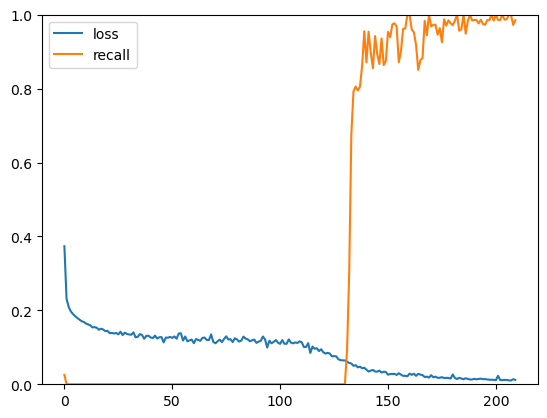

In [69]:
# Plot training metrics

plt.figure()
plt.plot(history['loss'], label="loss")
plt.plot(history['recall'], label="recall")
plt.legend()
plt.ylim(0,1)


## TEST ON Sample Clip

100%|██████████| 263/263 [00:00<00:00, 22637.95it/s]


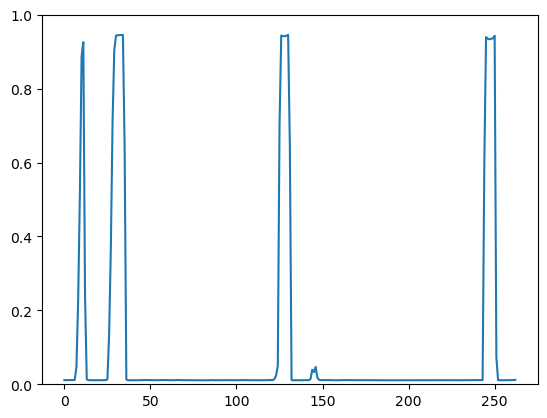

In [70]:
# Load data
sr, dat = scipy.io.wavfile.read("./1_clip_data/test_long_hi_kaoyi.wav")

# Pre-compute audio features using helper function
features = F._get_embeddings(dat)

# Get predictions for each window
scores = []
for i in tqdm(range(0, features.shape[0]-28)): # 28 is the number of timestep frames for this model
    window = features[i:i+28][None,]
    with torch.no_grad():
        scores.append(float(fcn(torch.from_numpy(window)).detach().numpy()))
    
plt.figure()
_ = plt.plot(scores)
_ = plt.ylim(0,1)


## 增加難度，提高背景音量

In [71]:
# Load two clips and mix them
_, dat = scipy.io.wavfile.read("./1_clip_data/test_long_hi_kaoyi.wav")
_, dat_music = scipy.io.wavfile.read("fma/000140.wav")
dat[-20*16000:] = (dat[-20*16000:] + dat_music[0:20*16000]*.7)/2 #quick manual mixing

ipd.display(ipd.Audio(dat[-16000*6:], rate=16000, normalize=True, autoplay=False))

100%|██████████| 263/263 [00:00<00:00, 30864.63it/s]


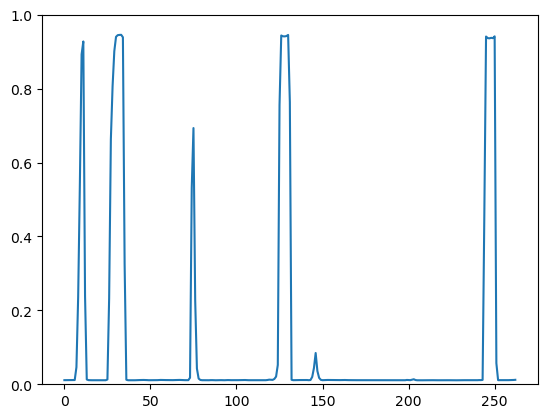

In [72]:
# Pre-compute audio features using helper function
features = F._get_embeddings(dat)

# Get predictions for each window
scores = []
for i in tqdm(range(0, features.shape[0]-28)): # 28 is the number of timestep frames for this model
    window = features[i:i+28][None,]
    with torch.no_grad():
        scores.append(float(fcn(torch.from_numpy(window)).detach().numpy()))
    
plt.figure()
_ = plt.plot(scores)
_ = plt.ylim(0,1)

# 輸出模型 Onnx 模型

In [73]:
# Export model to ONNX format

output_path = "hi_kmu_0721.onnx"
torch.onnx.export(fcn, args=torch.zeros((1, 28, 96)), f=output_path) # the 'args' is the shape of a single example

In [74]:
# Create openWakeWord instance
from openwakeword.model import Model

oww = Model(
    wakeword_models=["hi_kmu_0721.onnx"],
    enable_speex_noise_suppression=True,
    vad_threshold=0.5
)

AttributeError: module 'openwakeword' has no attribute 'get_pretrained_model_paths'